## MIDS W207 Final Project: Home Price Prediction

### Import packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

### Load data 

In [0]:
df = pd.read_csv('train.csv')

In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.shape

(1460, 81)

### Split data into train and dev set

In [0]:
train_y = np.log(df[:1000]['SalePrice'])
dev_y = np.log(df[1000:]['SalePrice'])
train_data = df[:1000].drop(['SalePrice', 'Id'], axis = 1)
dev_data = df[1000:].drop(['SalePrice', 'Id'], axis = 1)

In [9]:
train_y.shape

(1000,)

In [10]:
dev_y.shape

(460,)

In [11]:
train_data.shape

(1000, 79)

In [12]:
dev_data.shape

(460, 79)

### EDA and data cleaning

(array([ 5.,  0.,  3.,  4.,  4.,  6., 18., 20., 17., 22., 45., 39., 51.,
        64., 59., 61., 45., 41., 38., 50., 45., 35., 26., 26., 23., 23.,
        23., 19., 19., 15., 13., 13., 14., 11.,  8.,  4.,  4.,  6.,  9.,
        11.,  7.,  3.,  5.,  5.,  1.,  3.,  4.,  4.,  4.,  2.,  3.,  2.,
         2.,  1.,  2.,  1.,  2.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 34900.,  42101.,  49302.,  56503.,  63704.,  70905.,  78106.,
         85307.,  92508.,  99709., 106910., 114111., 121312., 128513.,
        135714., 142915., 150116., 157317., 164518., 171719., 178920.,
        186121., 193322., 200523., 207724., 214925., 222126., 229327.,
        236528., 243729., 250930., 258131., 265332., 272533., 279734.,
        286935., 294136., 301337., 308538., 315739., 322940., 330141.,
        

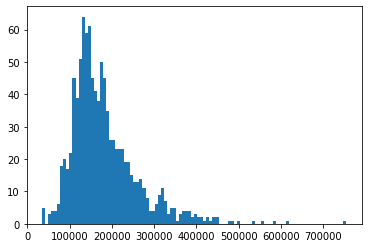

In [13]:
plt.hist(df[:1000]['SalePrice'], bins = 100)

(array([ 2.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  0.,  2.,  2.,  0.,  1.,  3.,  0.,  0.,  2.,  3.,
         7.,  6.,  6.,  8.,  9.,  5.,  4., 10., 10.,  7., 19., 26., 16.,
        19., 18., 23., 42., 29., 38., 45., 35., 28., 32., 31., 29., 26.,
        40., 32., 32., 27., 22., 22., 21., 19., 22., 18., 26.,  9., 18.,
        15., 14., 14.,  9.,  3.,  8., 14., 12.,  4.,  9.,  3.,  3.,  6.,
         8.,  3.,  2.,  3.,  4.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([10.46024211, 10.49098442, 10.52172673, 10.55246904, 10.58321134,
        10.61395365, 10.64469596, 10.67543827, 10.70618058, 10.73692289,
        10.7676652 , 10.79840751, 10.82914982, 10.85989213, 10.89063444,
        10.92137675, 10.95211906, 10.98286136, 11.01360367, 11.04434598,
        11.07508829, 11.1058306 , 11.13657291, 11.16731522, 11.19805753,
        11.22879984, 11.25954215, 11.29028446, 11.32102677, 11.351769

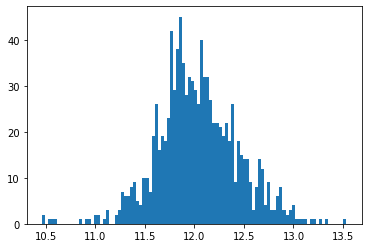

In [14]:
plt.hist(np.log(df[:1000]['SalePrice']), bins = 100)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1000 non-null   int64  
 1   MSZoning       1000 non-null   object 
 2   LotFrontage    827 non-null    float64
 3   LotArea        1000 non-null   int64  
 4   Street         1000 non-null   object 
 5   Alley          65 non-null     object 
 6   LotShape       1000 non-null   object 
 7   LandContour    1000 non-null   object 
 8   Utilities      1000 non-null   object 
 9   LotConfig      1000 non-null   object 
 10  LandSlope      1000 non-null   object 
 11  Neighborhood   1000 non-null   object 
 12  Condition1     1000 non-null   object 
 13  Condition2     1000 non-null   object 
 14  BldgType       1000 non-null   object 
 15  HouseStyle     1000 non-null   object 
 16  OverallQual    1000 non-null   int64  
 17  OverallCond    1000 non-null   int64  
 18  YearBuilt

#### Identify missing data

In [16]:
# Identify the missing data and calculate the percentage by column.
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,998,0.998
MiscFeature,957,0.957
Alley,935,0.935
Fence,806,0.806
FireplaceQu,478,0.478
LotFrontage,173,0.173
GarageType,56,0.056
GarageFinish,56,0.056
GarageQual,56,0.056
GarageCond,56,0.056


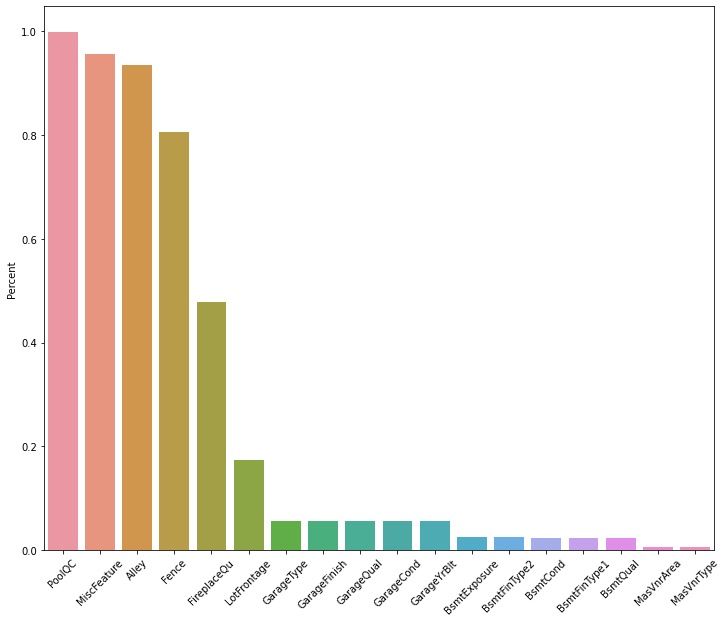

In [17]:
plt.figure(figsize=(12,10))
sns.barplot(x=missing_data[:18].index, y=missing_data[:18]['Percent'])
plt.xticks(rotation=45)
plt.show()

#### Noticing that there are a few columns with non-trivial fraction (> 40%, arbitrary) of  missing data, we decide not to include them for further analysis.

In [0]:
cols_to_delete = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
train_data= train_data.drop(columns = cols_to_delete)
dev_data = dev_data.drop(columns = cols_to_delete)

In [19]:
train_data.shape

(1000, 74)

In [20]:
dev_data.shape

(460, 74)

#### For the other columns with trivial fraction of missing data, we decide to fix them in the follwing way.

In [0]:
# all missing values for the categorical columns will be replaced by "None"
# all missing values for the numeric columns will be replaced by median of that field

for col in train_data.columns:
    if train_data[col].dtypes == 'O':
        train_data[col] = train_data[col].replace(np.nan,"None")
    else:
        train_data[col] = train_data[col].replace(np.nan,train_data[col].median())

for col in dev_data.columns:
    if dev_data[col].dtypes == 'O':
        dev_data[col] = dev_data[col].replace(np.nan,"None")
    else:
        dev_data[col] = dev_data[col].replace(np.nan,dev_data[col].median())

#### Obviously we have both numeric and categorical features, we can split them for convenience.

In [0]:
num_cols = []
cat_cols = []
for col in train_data.columns:
    if train_data[col].dtypes == 'O':
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [23]:
num_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [24]:
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

#### In fact, the feature 'MSSubClass' uses integer as identifier for dweling type, so we should remove it to the categorical set.

In [0]:
num_cols.remove('MSSubClass')
cat_cols.append('MSSubClass')

### Linear regression using all the numeric features

In [26]:
lr = LinearRegression()
lr.fit(train_data[num_cols], train_y)
lr.score(train_data[num_cols], train_y)

0.8867284579667323

In [27]:
pred = lr.predict(dev_data[num_cols])
np.sqrt(metrics.mean_squared_error(dev_y, pred))

0.18086784257099606

### Correlation matrix

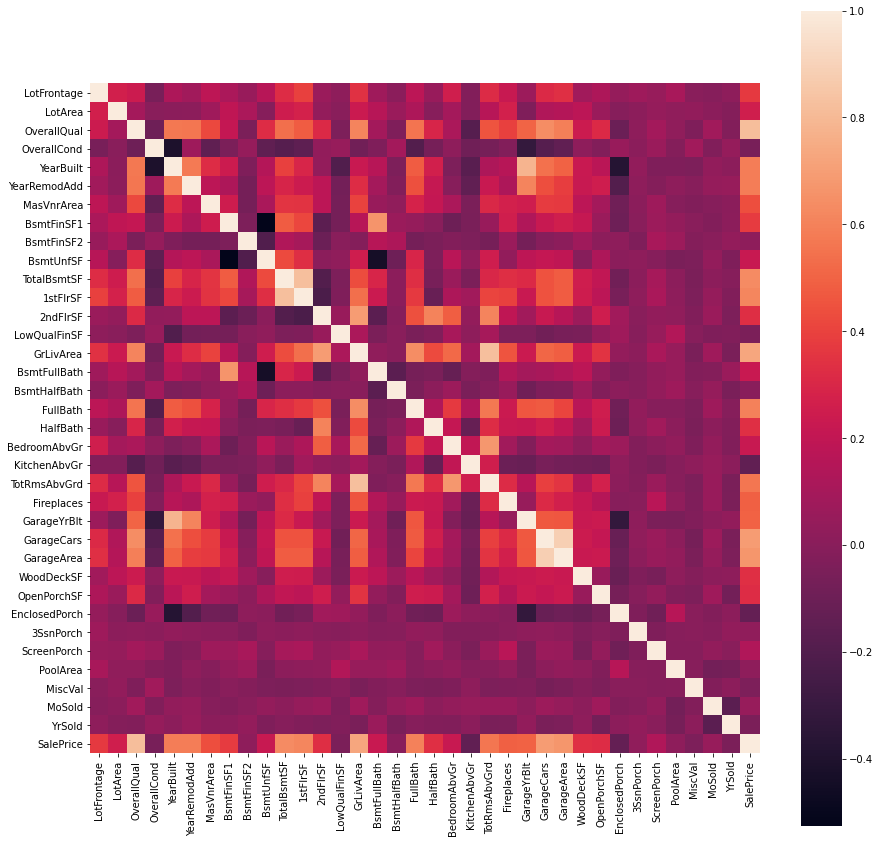

In [28]:
# Comprehensive correlation analysis 
corrmat = pd.concat([train_data[num_cols], train_y], axis = 1).corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, square=True)

### Bivariate analysis between numeric features and sale price.

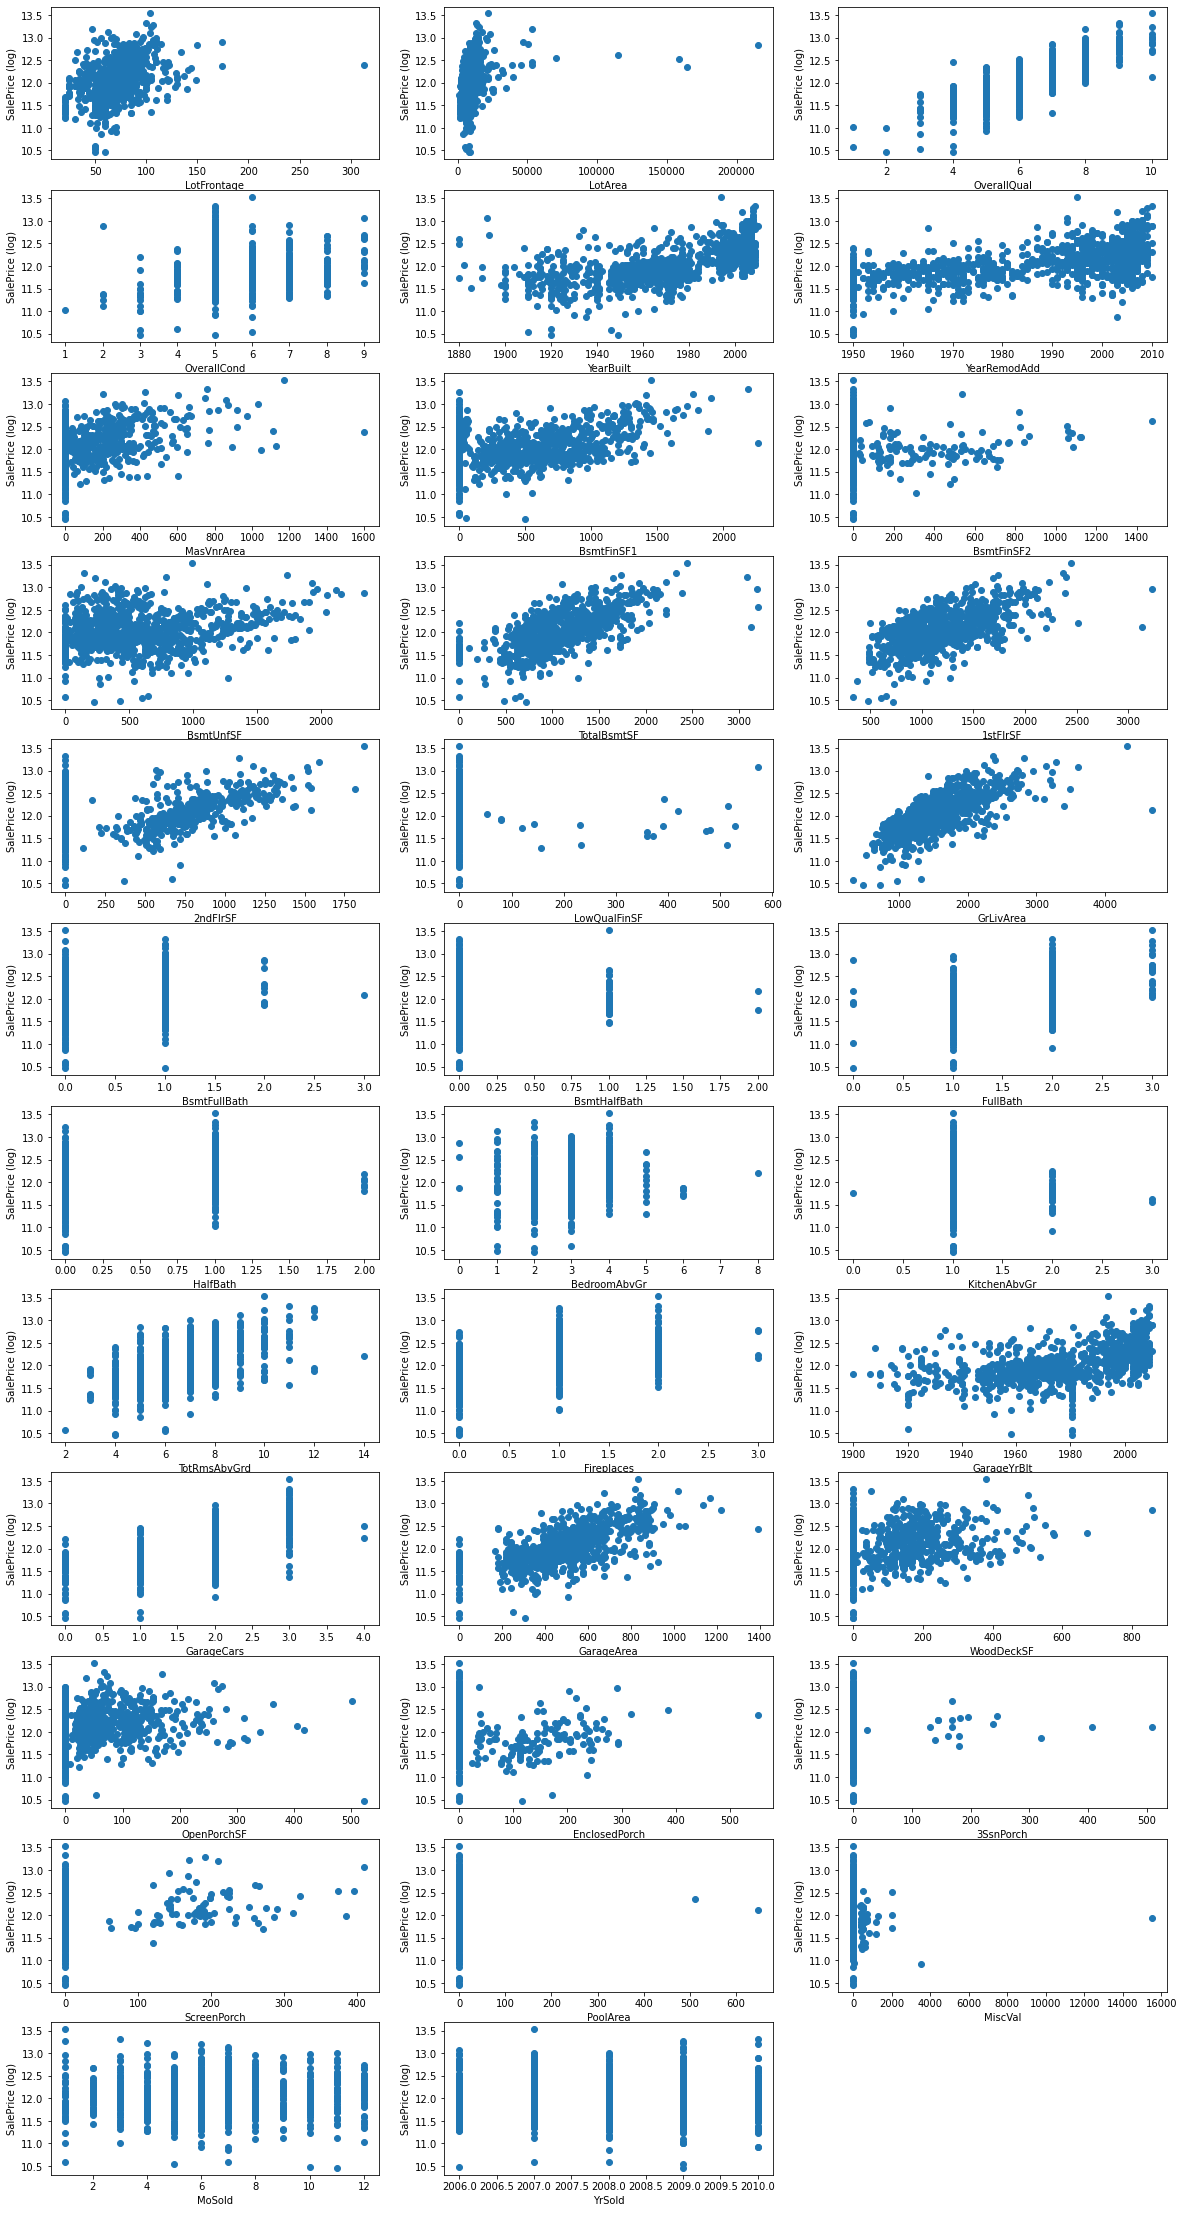

In [29]:
plt.figure(figsize=(20,50))
for idx,col in enumerate(num_cols):
    plt.subplot(15,3,idx+1)
    plt.scatter(x = train_data[col],y= train_y)
    plt.ylabel("SalePrice (log)")
    plt.xlabel(col)

#### From the correlation matrix and the bivariate analysis above, we can tell that (1) some features are more strongly linearly correlated with sale price than the others; (2) the correlation between features can be fairly strong and (3) for the features not showing strong correlation with sale price, feature engineering may help reveal correlation based on the common sense.

### Feature selection and linear regression

In [30]:
# Use an arbitrary criteria of pearson's correlation larger than 0.5 to select features.
select_num_cols = []
print('Pearson correlation between features and sale price:')
for col in num_cols:
    corr, _ = pearsonr(train_data[col], train_y)
    print(col, ':', corr)
    if abs(corr) > 0.5: select_num_cols.append(col)
print(select_num_cols)

Pearson correlation between features and sale price:
LotFrontage : 0.3696251938162749
LotArea : 0.2567722870150201
OverallQual : 0.8203565230042019
OverallCond : -0.05672470819377539
YearBuilt : 0.5884253049857875
YearRemodAdd : 0.5827953139730949
MasVnrArea : 0.43904654935680254
BsmtFinSF1 : 0.3761189745779125
BsmtFinSF2 : 0.016722236554562855
BsmtUnfSF : 0.2232335390448978
TotalBsmtSF : 0.6362645209834036
1stFlrSF : 0.6161626956166423
2ndFlrSF : 0.33115439097768545
LowQualFinSF : -0.047768440344676796
GrLivArea : 0.7295761063256154
BsmtFullBath : 0.2275304012841473
BsmtHalfBath : 8.84243077112013e-06
FullBath : 0.5993270567525847
HalfBath : 0.3334032268750317
BedroomAbvGr : 0.2207985046101933
KitchenAbvGr : -0.14110650879486156
TotRmsAbvGrd : 0.5629699212377332
Fireplaces : 0.48903710036541365
GarageYrBlt : 0.4960419345332212
GarageCars : 0.6921149387861142
GarageArea : 0.6693708607198884
WoodDeckSF : 0.3343860207877158
OpenPorchSF : 0.320871054638388
EnclosedPorch : -0.1315926109628

In [31]:
lr = LinearRegression()
lr.fit(train_data[select_num_cols], train_y)
lr.score(train_data[select_num_cols], train_y)

0.8438590138077033

In [32]:
pred = lr.predict(dev_data[select_num_cols])
np.sqrt(metrics.mean_squared_error(dev_y, pred))

0.19455203021453527

### Feature engineering and linear regression

#### Although the feature of year sold doesn't show strong correlation with sale price, the house age plays an important role in buyer's purchase decision. Usually the newer a house is, the higher it can sell for. Accordingly, we can engineer two features to reveal the relevant information: (1) house age = year built - year sold and (2) remodel age = year remodel add - year sold.

In [0]:
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
dev_data['HouseAge'] = dev_data['YrSold'] - dev_data['YearBuilt']
train_data['RemodAge'] = train_data['YrSold'] - train_data['YearRemodAdd']
dev_data['RemodAge'] = dev_data['YrSold'] - dev_data['YearRemodAdd']

In [34]:
corr,_ = pearsonr(train_data['HouseAge'], train_y)
print('Pearson correlation between HouseAge and SalePrice:', corr)
corr,_ = pearsonr(train_data['RemodAge'], train_y)
print('Pearson correlation between RemodAge and SalePrice:', corr)

Pearson correlation between HouseAge and SalePrice: -0.5900685913201703
Pearson correlation between RemodAge and SalePrice: -0.5863113452542096


In [0]:
# Compose new data set with both the selected and the engineered numeric features.
train_data_num = pd.concat([train_data[select_num_cols],train_data['HouseAge'],train_data['RemodAge']], axis = 1)
dev_data_num = pd.concat([dev_data[select_num_cols],dev_data['HouseAge'],dev_data['RemodAge'],], axis = 1)

In [36]:
lr = LinearRegression()
lr.fit(train_data_num, train_y)
lr.score(train_data_num, train_y)

0.8442106505481792

In [37]:
pred = lr.predict(dev_data_num)
np.sqrt(metrics.mean_squared_error(dev_y, pred))

0.1947872906964553

In [0]:
### Convert categorical variables to numeric variables
#### Get dummy variables from the categorical variables and concate with the numeric variables

In [0]:
df_dummies = pd.get_dummies(df[cat_cols], drop_first=True)

In [40]:
df_dummies.shape

(1460, 197)

In [41]:
df_num = df[num_cols]
df_num.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [42]:
df_num_dummies = pd.concat([df_dummies, df_num], axis = 1)
df_num_dummies.shape

(1460, 232)

In [43]:
df_num_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 232 entries, MSSubClass to YrSold
dtypes: float64(3), int64(33), uint8(196)
memory usage: 690.2 KB


In [0]:
# Fix the missing data.
for col in df_num_dummies.columns:
    df_num_dummies[col] = df_num_dummies[col].replace(np.nan,df_num_dummies[col].median())

In [0]:
train_num_dummies = df_num_dummies[:1000]
dev_num_dummies = df_num_dummies[1000:]

In [46]:
lr = LinearRegression()
lr.fit(train_num_dummies, train_y)
lr.score(train_num_dummies, train_y)

0.9451358894861114

In [47]:
pred = lr.predict(dev_num_dummies)
np.sqrt(metrics.mean_squared_error(dev_y, pred))

0.16756415851270265

### PCA

In [0]:
# Select the first k principle components explaining high fraction of total variance
training_score = []
rmse = []
for k in range(1,200,1):
    pca = PCA(n_components = k)
    train_num_dummies_kd = pca.fit_transform(train_num_dummies)
    
    lr = LinearRegression()
    lr.fit(train_num_dummies_kd, train_y)
    training_score.append(lr.score(train_num_dummies_kd, train_y))
    
    pred = lr.predict(pca.transform(dev_num_dummies))
    rmse.append(np.sqrt(metrics.mean_squared_error(dev_y, pred)))

Text(0, 0.5, 'Linear regression training score')

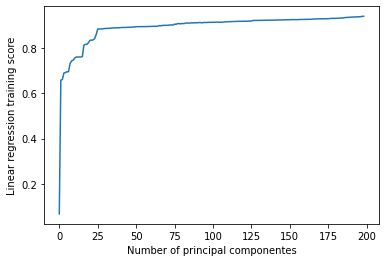

In [49]:
plt.figure()
plt.plot(training_score)
plt.xlabel('Number of principal componentes')
plt.ylabel('Linear regression training score')

Text(0, 0.5, 'RMSE')

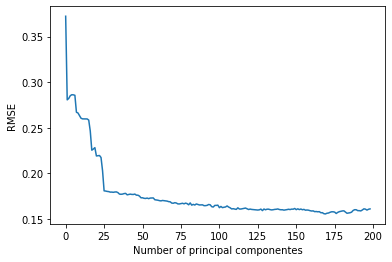

In [50]:
plt.figure()
plt.plot(rmse)
plt.xlabel('Number of principal componentes')
plt.ylabel('RMSE')

In [0]:
pca = PCA(n_components = 168)
train_num_dummies_kd = pca.fit_transform(train_num_dummies)

In [52]:
lr = LinearRegression()
lr.fit(train_num_dummies_kd, train_y)
lr.score(train_num_dummies_kd, train_y)

0.9299748524405191

In [53]:
pred = lr.predict(pca.transform(dev_num_dummies))
np.sqrt(metrics.mean_squared_error(dev_y, pred))

0.15718569352347894

In [54]:
rmse.index(min(rmse))

169

In [55]:
min(rmse)

0.1554198993193879

## **Julie's Random Forest**

In [61]:
train_data.shape

(1000, 76)

In [62]:
train_data[num_cols].shape

(1000, 35)

In [63]:
train_num_dummies.shape

(1000, 232)

In [60]:
train_num_dummies_kd.shape

(1000, 168)

#Run Random Forest on previously preprocessed data

##Let's try out Decision Tree model first

In [69]:
from sklearn.tree import DecisionTreeRegressor

# Run Decision Tree first on train_num_dummies:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_num_dummies, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [71]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(train_num_dummies)
tree_mse = mean_squared_error(train_y, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

3.1371236041042935e-05

Hmm: The RMSE is very small, no error at all? Could this model is overfitting? How can we be sure? The best way is to use Cross-Validation to check out.
[link text](https://)

In [76]:
from sklearn.model_selection import cross_val_score

# we get the best RMSE on train_num_dummies (other processed train data result in worse result)
scores = cross_val_score(tree_reg, train_num_dummies, train_y,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [0.22561559 0.19188899 0.21806381 0.21662062 0.25822495 0.23614076
 0.26355852 0.17468501 0.19446544 0.19047812]
Mean: 0.21697418037258767
Standard deviation: 0.02818048275228125


Now the Decision Tree doesn't look as good as it did earlir. In fact, it seems to perform worse than the Linear Regression model (RMSE = 0.16756415851270265). The Decision Tree is overfitting so badly that it performs worse than the Linear Regression Model.

##Now, let's try another model: the Random Forest Regressor.

Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions.


In [91]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(train_num_dummies, train_y)

housing_predictions = forest_reg.predict(train_num_dummies)
forest_mse = mean_squared_error(train_y, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.05583394480677634

In [92]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_num_dummies, train_y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.16272204 0.14020929 0.12254776 0.1203961  0.19216575 0.15503283
 0.18489193 0.12524453 0.13609442 0.15672899]
Mean: 0.14960336269983143
Standard deviation: 0.023996573813716036


It is **better**: Random Forest look very promising. But is there a way to fine-tune our models? Grid Search !

## Fine-Tune Random Forest Model

In [93]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_num_dummies, train_y)


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

The best hyperparameter combination found:


In [94]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [96]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.24156462148952976 {'max_features': 2, 'n_estimators': 3}
0.1946891169587433 {'max_features': 2, 'n_estimators': 10}
0.18567191374415762 {'max_features': 2, 'n_estimators': 30}
0.22071476026760872 {'max_features': 4, 'n_estimators': 3}
0.19150434041128134 {'max_features': 4, 'n_estimators': 10}
0.1766546878702578 {'max_features': 4, 'n_estimators': 30}
0.21882262374928937 {'max_features': 6, 'n_estimators': 3}
0.18293350619551124 {'max_features': 6, 'n_estimators': 10}
0.17271797293606636 {'max_features': 6, 'n_estimators': 30}
0.21292157723979507 {'max_features': 8, 'n_estimators': 3}
0.18162904939049287 {'max_features': 8, 'n_estimators': 10}
0.17118087139021418 {'max_features': 8, 'n_estimators': 30}
0.2334733380169862 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.19436040761533352 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.2198644455355652 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.18631439099968314 {'bootstrap': False, 'max_feat

Curiously, our result of Grid Search is not as good as without it. Let's try out RandomizeSearchCV

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=10, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_num_dummies, train_y)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [98]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.16282209433140452 {'max_features': 7, 'n_estimators': 180}
0.1761238705345868 {'max_features': 5, 'n_estimators': 15}
0.1765574894647687 {'max_features': 3, 'n_estimators': 72}
0.17625938410276895 {'max_features': 5, 'n_estimators': 21}
0.16370962571757172 {'max_features': 7, 'n_estimators': 122}
0.1763015557807145 {'max_features': 3, 'n_estimators': 75}
0.1764155870287767 {'max_features': 3, 'n_estimators': 88}
0.16930213266111102 {'max_features': 5, 'n_estimators': 100}
0.17579939148540272 {'max_features': 3, 'n_estimators': 150}
0.24003346455334978 {'max_features': 5, 'n_estimators': 2}


RandomizedSearchCV results in better result but globally, Random Forest is still not much better than Linear Regression Model.



## Let's see which features are the most important to our models

In [104]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances
colnames=train_num_dummies.columns.values.tolist()
feature_sorted=sorted(zip(feature_importances, colnames), reverse=True)
feature_sorted[0:10]

[(0.05664239846626932, 'TotalBsmtSF'),
 (0.054129855381588675, 'OverallQual'),
 (0.05307823565008385, 'YearBuilt'),
 (0.043929226570570724, '1stFlrSF'),
 (0.04265578249804336, 'GarageCars'),
 (0.039695657036795576, 'GrLivArea'),
 (0.03305971424711065, 'FullBath'),
 (0.03099901118092924, 'OpenPorchSF'),
 (0.029905398184901642, 'LotFrontage'),
 (0.029286805418496938, 'KitchenQual_TA')]